In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import time
from functools import cmp_to_key

In [2]:
# Constants
HORIZONTAL = 0
VERTICAL = 1
red = (220,0,0)
blue = (0,120,170)

class Car:
  next_id = 2
  @staticmethod
  def reset_id_generator():
    Car.next_id = 2
  
  def __init__(self, column:int, row:int, orientation:int, size:int, is_red=False) -> None:
    self.color = blue
    if is_red:
      self.id = 1
      self.color = red
    else:
      self.id = Car.next_id
      Car.next_id += 1
    self.column = column
    self.row = row
    self.orientation = orientation
    self.size = size

  def is_horizontal(self):
    return self.orientation == HORIZONTAL 
  
  def occupied_cells(self):
    cells = []
    if self.is_horizontal():
      for dx in range(self.size):
        cells.append((self.column + dx, self.row))
    else:
      for dy in range(self.size):
        cells.append((self.column, self.row + dy))
    return cells
  
  # each car has a constant position that never changes and a variable position
  # for horizontal cars: the constant position is the row
  #                      the variable one is the column
  # for vertical cars it is the inverse
  def get_variable_position(self):
    if self.is_horizontal():
      return self.column
    return self.row
  
  def get_constant_position(self):
    if self.is_horizontal():
      return self.row
    return self.column

  def possible_moves(self, parking):
    moves = []
    x = self.column
    y = self.row
    if self.is_horizontal():
      dx = -1
      while parking.is_free(x+dx,y) :
        moves.append(dx)
        dx -= 1
      dx = 1
      while parking.is_free(x + self.size-1 + dx,y):
        moves.append(dx)
        dx += 1
    else:
      dy = -1
      while parking.is_free(x,y+dy) :
        moves.append(dy)
        dy -= 1
      dy = 1
      while parking.is_free(x,y + self.size-1 + dy):
        moves.append(dy)
        dy += 1
    return moves
  
  def move(self, dxy):
    if self.is_horizontal():
      self.column += dxy
    else:
      self.row += dxy



class Parking:
  def __init__(self, width:int, height:int) -> None:
    self.width = width
    self.height = height
    self.board = np.zeros((width, height), dtype=int)
  
  def put_car(self, car:Car):
    car_cells = car.occupied_cells()
    # check that the car emplacement is free
    for (x,y) in car_cells:
      if not self.is_free(x,y):
        return False
    # put the car in parking
    for (x,y) in car_cells:
      self.board[x,y] = car.id
    return True
  
  def car_on_cell(self,x,y):
    if (x<0 or x>=self.width):
      return -1
    if (y<0 or y>=self.height):
      return -1
    return self.board[x,y]
  
  def is_free(self,x,y):
    return (self.car_on_cell(x,y) == 0)
  
  def remove(self, car:Car):
    car_cells = car.occupied_cells()
    for (x,y) in car_cells:
      self.board[x,y] = 0



In [3]:
class RushHour:
  def __init__(self, parking) -> None:
    self.parking = parking
    self.cars = {}
    Car.reset_id_generator()
    self.car_ids = [] # need to keep a fixed order of the ids for "int_repr"
    # the maximum possible position for a car (assuming it has a size >1) is: 
    self.max_pos = max(self.parking.width, self.parking.height) - 2
  
  def int_repr(self):
    # the integer representation is the positions of the cars written in base max_pos
    state = 0
    power = 1
    for id in self.car_ids:
      state += power * self.cars[id].get_variable_position()
      power *= self.max_pos
    return state
  
  def add_car(self, car:Car):
    if self.parking.put_car(car):
      self.cars[car.id] = car
      self.car_ids.append(car.id)
      return True
    print(f"car {car.id} could not be added because position is invalid or taken")
    return False

  def possible_moves(self, leave=-1):
    moves = []
    for car_id in self.cars:
      if car_id != leave: 
        car_moves = self.cars[car_id].possible_moves(self.parking)
        for dxy in car_moves:
          moves.append((car_id, dxy))
    return moves

  def move_car(self, move):
    """
    - move must be an available move for the car
    """
    car_id, dxy = move
    car = self.cars[car_id]
    # move the car
    self.parking.remove(car)
    car.move(dxy)
    # if the parking emplacement is not free, move the car back to its first place
    if not self.parking.put_car(car):
      car.move(-dxy)
      self.parking.put_car(car)
      return False
    return True
  
  def cancel_move_car(self, move):
    car_id, dxy = move
    self.move_car((car_id, -dxy))

  def won(self):
    """
    - the game is won if there are no obstacles between the red
      car and the last cell of its row
    """
    red_car = self.cars[1]
    for column in range(red_car.column + red_car.size, self.parking.width):
      if not self.parking.is_free(column, red_car.row):
        return False
    return True
  
  def dist_to_exit(self):
    red_car = self.cars[1]
    return self.parking.width - (red_car.column + red_car.size);

In [4]:
class Drawing:
  CELL_SIZE = 50
  MARGIN = CELL_SIZE // 8

  @staticmethod
  def show_grid(parking, img, color=(150,150,150)):
    xmin, ymin = 0, 0
    xmax = parking.width*Drawing.CELL_SIZE
    ymax = parking.height*Drawing.CELL_SIZE
    for row in range(1, parking.height):
      y = row * Drawing.CELL_SIZE
      cv2.line(img, (xmin,y), (xmax,y), color, 1)
    for column in range(1, parking.width):
      x = column * Drawing.CELL_SIZE
      cv2.line(img, (x,ymin), (x,ymax), color, 1)

  @staticmethod
  def show_car(car, img):
    CELL_SIZE = Drawing.CELL_SIZE
    MARGIN = Drawing.MARGIN
    if car.is_horizontal():
      xmin = car.column * CELL_SIZE + MARGIN
      ymin = car.row * CELL_SIZE + MARGIN
      xmax = (car.column + car.size) * CELL_SIZE - MARGIN
      ymax = (car.row + 1) * CELL_SIZE - MARGIN
    else:
      xmin = car.column * CELL_SIZE + MARGIN
      ymin = car.row * CELL_SIZE + MARGIN
      xmax = (car.column + 1) * CELL_SIZE - MARGIN
      ymax = (car.row + car.size) * CELL_SIZE - MARGIN
    cv2.rectangle(img, (xmin,ymin), (xmax,ymax), car.color, (-1))
    cv2.rectangle(img, (xmin,ymin), (xmax,ymax), (0,0,0), (2))
  
  @staticmethod
  def show_parking(rush_hour):
    parking = rush_hour.parking
    img_height = Drawing.CELL_SIZE * parking.height
    img_width = Drawing.CELL_SIZE * parking.width
    img = np.zeros((img_height, img_width, 3), dtype="uint8")
    img[:,:,:] = (200,200,170)

    Drawing.show_grid(parking, img)
    for car in rush_hour.cars.values():
      Drawing.show_car(car, img)
    
    return img

def imshow(img):
  plt.figure(figsize=(6,6))
  plt.axis('off')
  plt.imshow(img) 
  plt.show() 

# **Solver BFS**

In [5]:
class Solver_BFS:
  @staticmethod
  def solve(puzzle):
    EXECUTE = 1
    EXPLORE = 0
    CANCEL = -1
    queue = []
    winning_moves = [] # stack
    possible_moves = puzzle.possible_moves()
    for move in possible_moves:
      queue.append((move, EXPLORE))
    visited = []
    depth = 1
    while len(queue) > 0:
      move, action = queue.pop(0)
      if action == EXPLORE:
        puzzle.move_car(move)
        if puzzle.won():
          winning_moves.append(move)
          break
        repr = puzzle.int_repr()
        if repr not in visited:
          queue.append((move, EXECUTE))
          visited.append(repr)
          next_moves = puzzle.possible_moves()
          for next_move in next_moves:
            queue.append((next_move, EXPLORE))
          queue.append((move, CANCEL))
        puzzle.cancel_move_car(move)
      elif action == EXECUTE:
        depth += 1
        puzzle.move_car(move)
        queue.append((move, EXECUTE))
        winning_moves.append(move)
      else:
        depth -= 1
        puzzle.cancel_move_car(move)
        queue.append((move, CANCEL))
        winning_moves.pop()
    for move in winning_moves[::-1]:
      puzzle.cancel_move_car(move)
    winning_moves.append((1,puzzle.dist_to_exit()))
    return winning_moves

# **Solver DFS**

In [6]:
class Solver_DFS:
  @staticmethod
  def solve_backtrack(puzzle, visited, winning_moves, leave=-1, max_moves=np.inf): 
    if puzzle.won():
      return True
    if max_moves == 0:
      return False
    repr = puzzle.int_repr()
    if repr in visited:
      return False
    visited.append(repr)
    moves = puzzle.possible_moves(leave=leave)
    random.shuffle(moves)
    for move in moves:
      puzzle.move_car(move)
      is_solved =  Solver_DFS.solve_backtrack(
      	  puzzle,
          visited,
          winning_moves,
          leave=move[0],
          max_moves=max_moves-1)
      puzzle.cancel_move_car(move)
      if is_solved:
        winning_moves.append(move)
        return True
    return False
  
  @staticmethod
  def solve(puzzle, max_moves=np.inf):
    visited = []
    winning_moves = []
    solved = Solver_DFS.solve_backtrack(puzzle, visited, winning_moves, max_moves)
    winning_moves.reverse()
    winning_moves.append((1,puzzle.dist_to_exit()))
    return solved, winning_moves

  @staticmethod
  def solve_best(puzzle, iters:int):
    best_moves = []
    min_moves = np.inf
    for n in range(iters):
      solved, winning_moves = Solver_DFS.solve(puzzle, max_moves=max(200, min_moves-1))
      if solved and len(winning_moves) < min_moves:
        best_moves = winning_moves[:]
        min_moves = len(winning_moves)
    return best_moves

## Tests

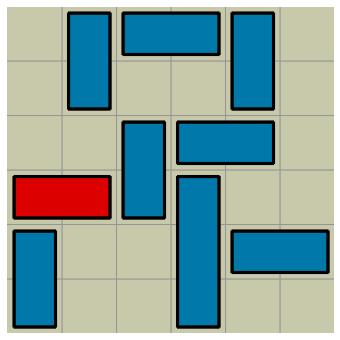

In [15]:
# Test Config easy
parking = Parking(6,6)
easy = RushHour(parking)

easy.add_car(Car(0,3,HORIZONTAL, 2, is_red=True))
easy.add_car(Car(2,0,HORIZONTAL,2))
easy.add_car(Car(3,2,HORIZONTAL,2))
easy.add_car(Car(4,4,HORIZONTAL,2))
easy.add_car(Car(4,0,VERTICAL,2))
easy.add_car(Car(1,0,VERTICAL,2))
easy.add_car(Car(3,3,VERTICAL, 3))
easy.add_car(Car(2,2,VERTICAL, 2))
easy.add_car(Car(0,4,VERTICAL, 2))

img = Drawing.show_parking(easy)
imshow(img)

In [16]:
moves_BFS = Solver_BFS.solve(easy)
moves_DFS = Solver_DFS.solve_best(easy, 20)

print("number of moves for solving the puzzle with Solver_BFS : ", len(moves_BFS))
print("number of moves for solving the puzzle with Solver_DFS : ", len(moves_DFS))

number of moves for solving the puzzle with Solver_BFS :  6
number of moves for solving the puzzle with Solver_DFS :  6


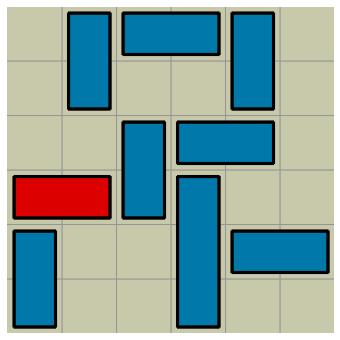

move num 1: (3, 1)
game won ? False


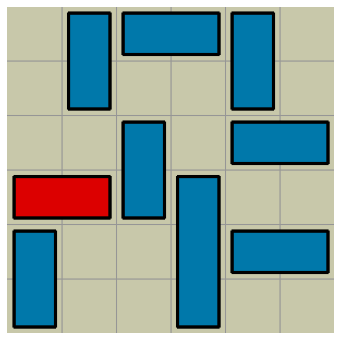

move num 2: (6, 1)
game won ? False


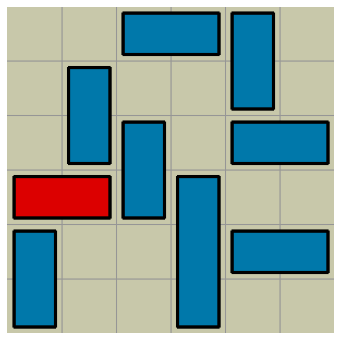

move num 3: (2, -1)
game won ? False


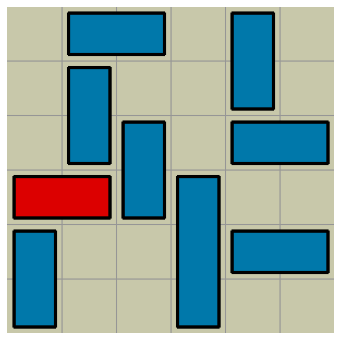

move num 4: (7, -3)
game won ? False


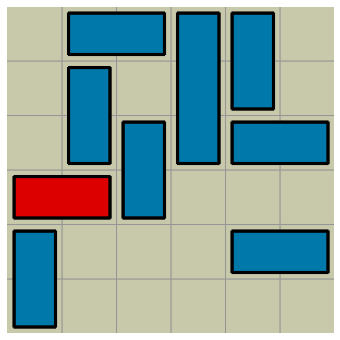

move num 5: (8, -1)
game won ? True


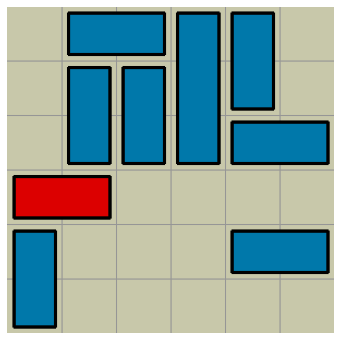

move num 6: (1, 4)
game won ? True


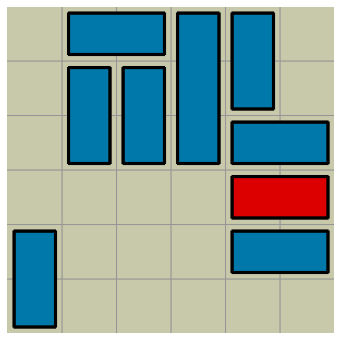

In [17]:
img = Drawing.show_parking(easy)
imshow(img)

for i in range(len(moves_BFS)):
  move = moves_BFS[i]
  easy.move_car(move)
  print(f"move num {i+1}: {move}")
  print(f"game won ? {easy.won()}")
  img = Drawing.show_parking(easy)
  imshow(img)

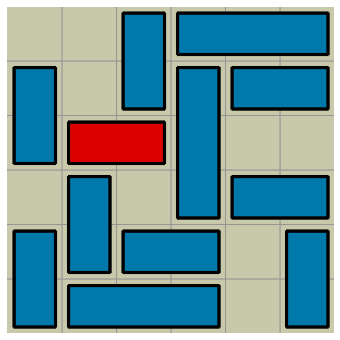

In [10]:
# Test Config hard
parking = Parking(6,6)
hard = RushHour(parking)

hard.add_car(Car(1,2,HORIZONTAL, 2, is_red=True))
hard.add_car(Car(3,0,HORIZONTAL,3))
hard.add_car(Car(4,1,HORIZONTAL,2))
hard.add_car(Car(4,3,HORIZONTAL,2))
hard.add_car(Car(2,4,HORIZONTAL,2))
hard.add_car(Car(1,5,HORIZONTAL,3))
hard.add_car(Car(2,0,VERTICAL,2))
hard.add_car(Car(3,1,VERTICAL,3))
hard.add_car(Car(0,1,VERTICAL, 2))
hard.add_car(Car(0,4,VERTICAL, 2))
hard.add_car(Car(1,3,VERTICAL, 2))
hard.add_car(Car(5,4,VERTICAL, 2))

img = Drawing.show_parking(hard)
imshow(img)

In [11]:
moves_BFS = Solver_BFS.solve(hard)

print("number of moves for solving the puzzle with Solver_BFS : ", len(moves_BFS))

number of moves for solving the puzzle with Solver_BFS :  26


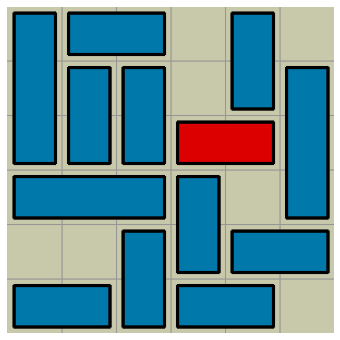

In [12]:
# Test Config hardest
parking = Parking(6,6)
hardest = RushHour(parking)

hardest.add_car(Car(3,2,HORIZONTAL, 2, is_red=True))
hardest.add_car(Car(1,0,HORIZONTAL,2))
hardest.add_car(Car(0,3,HORIZONTAL,3))
hardest.add_car(Car(0,5,HORIZONTAL,2))
hardest.add_car(Car(3,5,HORIZONTAL,2))
hardest.add_car(Car(4,4,HORIZONTAL,2))
hardest.add_car(Car(0,0,VERTICAL,3))
hardest.add_car(Car(1,1,VERTICAL,2))
hardest.add_car(Car(2,1,VERTICAL,2))
hardest.add_car(Car(4,0,VERTICAL,2))
hardest.add_car(Car(3,3,VERTICAL,2))
hardest.add_car(Car(2,4,VERTICAL,2))
hardest.add_car(Car(5,1,VERTICAL,3))

img = Drawing.show_parking(hardest)
imshow(img)

In [13]:
moves_BFS = Solver_BFS.solve(hardest)

print("number of moves for solving the puzzle with Solver_BFS : ", len(moves_BFS))

number of moves for solving the puzzle with Solver_BFS :  51
